# Evolutionary algorithm experiments

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import random

from constants import PATH_PURE_COMPONENTS, PATH_MIXTURES, X
from file_io import load_pickle_file
from fit_with_x_axis_correction.common import *
from fit_with_x_axis_correction.correction_models import *

from numpy.random import normal

logging.basicConfig(level=logging.INFO)

In [3]:
logger = logging.getLogger(__name__)

## Load data

In [4]:
pure_components = load_pickle_file(PATH_PURE_COMPONENTS)
mixtures_data = load_pickle_file(PATH_MIXTURES)

## Analysis

### Constants

In [5]:
N_POPULATION = 200
N_SURVIVORS = 30
N_LINEAR_COMBINATIONS = 30
N_MUTATIONS = 100
INIT_GUESS = [0, 0, 0]
INIT_DEVIATIONS = [0.01, 0.1, 1]
N_MAX_GENERATIONS = 300
RSME_THRESHOLD = 2
N_STEADY_THRESHOLD = 50
MAX_X_DEVIATION = 50

In [6]:
correction_model = quadratic_correction
x_original = X
signal = mixtures_data[0]['signal']
true = mixtures_data[0]['contributions']

### Optimization

In [7]:
correction_model = quadratic_correction
n_population: int = 50
n_survivors: int = None
n_crossovers: int = None
n_mutations: int = None
init_guess: Tuple[float] = (0, 0, 0)
deviations: Tuple[float] = (0.01, 0.1, 1)
deviations_scaling: Tuple[float] = None
n_max_generations: int = 500
rsme_threshold: float = 1
n_no_change_threshold: int = 50
max_x_deviation: float = None
scaled_proportion = 0.7

In [8]:
all_rsme_values = []

In [9]:
# Initialize optional arguments if not given
if not max_x_deviation:
    max_x_deviation = (max(x_original) - min(x_original)) // 2
if not deviations_scaling:
    deviations_scaling = np.array([1 / k for k in range(1, n_max_generations + 1)])

# Initialize parameter candidates
parameters = []
for _ in range(n_population):
    candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(init_guess, deviations)]
    parameters.append(candidate)
parameters = np.array(parameters)

# Initialize optimization
min_rsme = float(np.inf)
return_solution, return_parameters = None, None
counter = 0

# Search for best parameter combination
for round in range(n_max_generations):
    counter += 1
    rsme_values = []

    for candidate in parameters:
        x_target = correction_model(x_original, candidate)

        # Check that interpolated x axis is within accepted range
        if abs(min(x_target) - min(x_original)) > max_x_deviation:
            rsme_values.append(float(np.inf))
            continue
        if abs(max(x_target) - max(x_original)) > max_x_deviation:
            rsme_values.append(float(np.inf))
            continue

        solution, residual = nnls_fit_with_interpolated_library(x_original, x_target, pure_components, signal)
        rsme_value = rsme(residual)
        rsme_values.append(rsme_value)

        # Update solution if RSME is smaller than current minimum
        if rsme_value < min_rsme:
            min_rsme = rsme_value
            return_solution = solution
            return_parameters = candidate
            counter = 0
            logger.info(f'Solution updated: Round {round}, RSME {min_rsme}')
    
    all_rsme_values.append(rsme_values)
    
    # Check termination conditions
    if min_rsme < rsme_threshold:
        logger.info(f'Target RSME reached. Iteration terminated at round {round}.')
        break
    if counter > n_no_change_threshold:
        logger.info(
            f"RSME didn't change in last {n_no_change_threshold} rounds. Iteration terminated at round {round}.")
        break
    if round == n_max_generations - 1:
        logger.warning(f"Maximum number of generations reached. Iteration terminated at round {round}.")
        break

    # Find best parameter combination
    index_lowest_rsme = np.argmin(rsme_values)
    best_parameters = parameters[index_lowest_rsme]

    # Generate new parameter combinations
    parameters = []
    parameters.append(best_parameters)
    scale = deviations_scaling[round]
    n_scaled = int(scaled_proportion * n_population)
    for _ in range(n_scaled):
        candidate = [normal(loc=mean, scale=scale * stdev) for mean, stdev in zip(best_parameters, deviations)]
        parameters.append(candidate)
    for _ in range(n_population - len(parameters)):
        candidate = [normal(loc=mean, scale=stdev) for mean, stdev in zip(best_parameters, deviations)]
        parameters.append(candidate)
    parameters = np.array(parameters)

INFO:__main__:Solution updated: Round 0, RSME 447.8079381766642
INFO:__main__:Solution updated: Round 0, RSME 132.6442529728223
INFO:__main__:Solution updated: Round 0, RSME 92.42121880445649
INFO:__main__:Solution updated: Round 2, RSME 90.33152880783412
INFO:__main__:Solution updated: Round 2, RSME 34.280856423200724
INFO:__main__:Solution updated: Round 3, RSME 30.2013048739256
INFO:__main__:Solution updated: Round 3, RSME 21.459620784625226
INFO:__main__:Solution updated: Round 4, RSME 18.26904583883674
INFO:__main__:Solution updated: Round 4, RSME 13.913399896451915
INFO:__main__:Solution updated: Round 6, RSME 7.742262742985859
INFO:__main__:Solution updated: Round 9, RSME 7.667426393270237
INFO:__main__:Solution updated: Round 12, RSME 7.576326443510769
INFO:__main__:Solution updated: Round 14, RSME 7.541099114658807
INFO:__main__:Solution updated: Round 16, RSME 7.400770938180927
INFO:__main__:Solution updated: Round 23, RSME 7.29228366101328
INFO:__main__:Solution updated: Rou

INFO:__main__:Solution updated: Round 295, RSME 5.642293988931629
INFO:__main__:Solution updated: Round 295, RSME 5.638609847730481
INFO:__main__:Solution updated: Round 296, RSME 5.634142117732688
INFO:__main__:Solution updated: Round 298, RSME 5.633400964394309
INFO:__main__:Solution updated: Round 299, RSME 5.616453985390979
INFO:__main__:Solution updated: Round 300, RSME 5.60916289161596
INFO:__main__:Solution updated: Round 301, RSME 5.602848538831498
INFO:__main__:Solution updated: Round 302, RSME 5.602341405117116
INFO:__main__:Solution updated: Round 303, RSME 5.58867378142271
INFO:__main__:Solution updated: Round 304, RSME 5.588192349616972
INFO:__main__:Solution updated: Round 304, RSME 5.58504774510045
INFO:__main__:Solution updated: Round 305, RSME 5.577882215886159
INFO:__main__:Solution updated: Round 306, RSME 5.57096287882889
INFO:__main__:Solution updated: Round 307, RSME 5.560167241048395
INFO:__main__:Solution updated: Round 310, RSME 5.556778714624259
INFO:__main__:

INFO:__main__:Solution updated: Round 481, RSME 5.048004526277487
INFO:__main__:Solution updated: Round 485, RSME 5.041072562073428
INFO:__main__:Solution updated: Round 486, RSME 5.038748435437896
INFO:__main__:Solution updated: Round 487, RSME 5.03785104399265
INFO:__main__:Solution updated: Round 488, RSME 5.036066607445201
INFO:__main__:Solution updated: Round 489, RSME 5.028487125830527
INFO:__main__:Solution updated: Round 489, RSME 5.027590718596945
INFO:__main__:Solution updated: Round 489, RSME 5.026662484571523
INFO:__main__:Solution updated: Round 491, RSME 5.022351166333634
INFO:__main__:Solution updated: Round 492, RSME 5.02036457153743
INFO:__main__:Solution updated: Round 492, RSME 5.019860688387911
INFO:__main__:Solution updated: Round 492, RSME 5.018464920054049
INFO:__main__:Solution updated: Round 495, RSME 5.017000287454951
INFO:__main__:Solution updated: Round 499, RSME 5.012637183890778


### Results

C:\Users\ossi\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


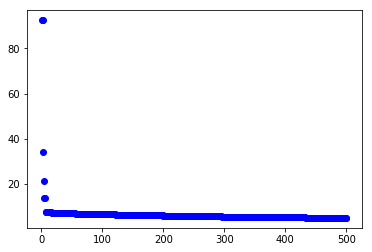

In [10]:
for i, row in enumerate(all_rsme_values,1):
    rsme_min = min(row)
    rsme_stdev = np.std(row)
    rsme_mean = np.mean(row)
    _ = plt.plot(i, rsme_min, 'bo')

## Test refactored version

In [11]:
from fit_with_x_axis_correction.EA import solve_with_EA

In [12]:
solution, parameters = solve_with_EA(x_original,signal,pure_components)

INFO:fit_with_x_axis_correction.EA:Solution updated: Round 0, RSME 313.5211440820412
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 0, RSME 206.55722796317306
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 0, RSME 156.37924905223537
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 0, RSME 6.841643331297963
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 5, RSME 4.496572919412696
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 10, RSME 4.301709692802334
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 11, RSME 2.658434655741153
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 16, RSME 2.486431043638357
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 23, RSME 2.2914341166170007
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 35, RSME 2.170314674507366
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 41, RSME 2.110381152506278
INFO:fit_with_x_axis_correction.EA:Solution updated: Rou

INFO:fit_with_x_axis_correction.EA:Solution updated: Round 244, RSME 1.208386015743818
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 245, RSME 1.205812389885268
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 245, RSME 1.2028333548641017
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 246, RSME 1.1942257141178625
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 248, RSME 1.191521892934945
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 249, RSME 1.184911050184948
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 251, RSME 1.1840476301827056
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 277, RSME 1.177068556950091
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 279, RSME 1.1764266252183526
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 280, RSME 1.1686582385530544
INFO:fit_with_x_axis_correction.EA:Solution updated: Round 281, RSME 1.1613243133296227
INFO:fit_with_x_axis_correction.EA:So